In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import time
from tensorflow.examples.tutorials.mnist import input_data
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

/usr/local/lib/python3.5/dist-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
def tic():
    global startTime_for_tictoc
    startTime_for_tictoc = time.time()

def toc():
    return time.time() - startTime_for_tictoc

In [3]:
def load_data():
    mnist = input_data.read_data_sets('MNIST_data/')
    images = np.append(np.append(mnist.train.images, mnist.validation.images, axis=0), mnist.test.images, axis=0)
    return images

In [4]:
def generator_output(noise_input, n_1, n_out, reuse=False):
    with tf.variable_scope('generator', reuse=reuse):
        A1 = tf.contrib.layers.fully_connected(noise_input, n_1, activation_fn=tf.nn.relu, scope='A1')
        A_out = tf.contrib.layers.fully_connected(A1, n_out, activation_fn=tf.nn.tanh, scope='A_out')
        return A_out

In [5]:
def discriminator_output(images, n_1, reuse=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        A1 = tf.contrib.layers.fully_connected(images, n_1, activation_fn=tf.nn.relu, scope='A1')
        Z_out = tf.contrib.layers.fully_connected(A1, 1, activation_fn=None, scope='Z_out')
        return Z_out

In [6]:
def MNIST_GAN(hyperparams):
    tf.reset_default_graph()
    mnist_images = load_data() * 2 - 1
    noise_size = hyperparams['noise_size']
    batch_size = hyperparams['batch_size']
    epoch = hyperparams['epoch']
    generator_n_1 = hyperparams['generator_n_1']
    discriminator_n_1 = hyperparams['discriminator_n_1']
    learning_rate = hyperparams['learning_rate']
    sample_size = hyperparams['sample_size']
    data_size = mnist_images.shape[0]
    image_size = mnist_images.shape[1]
    total_batches = np.ceil(data_size / batch_size).astype(np.int32)
    real_images = tf.placeholder(tf.float32, (None, image_size), name='real_images')
    noise_input = tf.placeholder(tf.float32, (None, noise_size), name='noise_input')
    fake_images = generator_output(noise_input, generator_n_1, image_size)
    real_logits = discriminator_output(real_images, discriminator_n_1)
    fake_logits = discriminator_output(fake_images, discriminator_n_1, reuse=True)
    dis_real_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=real_logits, labels=tf.ones_like(real_logits)))
    dis_fake_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.zeros_like(fake_logits)))
    dis_cost = tf.divide(tf.add(dis_real_cost, dis_fake_cost), 2)
    gen_cost = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=fake_logits, labels=tf.ones_like(fake_logits)))
    trainable_vars = tf.trainable_variables()
    gen_vars = [var for var in trainable_vars if var.name.startswith('generator')]
    dis_vars = [var for var in trainable_vars if var.name.startswith('discriminator')]
    gen_optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(gen_cost, var_list=gen_vars)
    dis_optimize = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(dis_cost, var_list=dis_vars)
    costs_history = []
    generate_sample_history = np.empty((0, sample_size, image_size))
    sample_noise_input = np.random.uniform(low=-1, high=1, size=(sample_size, noise_size))
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    with tf.Session(config=config) as sess:
        sess.run(tf.global_variables_initializer())
        for i in range(epoch):
            tic()
            noises = np.empty((0, noise_size))
            for j in range(total_batches):
                index_front = j * batch_size
                index_end = (j + 1) * batch_size if (j + 1) * batch_size < data_size else data_size
                images_batch = mnist_images[index_front:index_end].reshape(-1, image_size)
                noise_batch = np.random.uniform(low=-1, high=1, size=(index_end - index_front, noise_size))
                sess.run(dis_optimize, feed_dict={real_images:images_batch, noise_input:noise_batch})
                sess.run(gen_optimize, feed_dict={noise_input:noise_batch})
                noises = np.append(noises, noise_batch, axis=0)
            dis_epoch_cost_real, dis_epoch_cost_fake, dis_epoch_cost, gen_epoch_cost = sess.run([dis_real_cost, dis_fake_cost, dis_cost, gen_cost], feed_dict={real_images:mnist_images, noise_input:noises})
            costs_history.append((dis_epoch_cost_real, dis_epoch_cost_fake, dis_epoch_cost, gen_epoch_cost))
            generate_sample_history = np.append(generate_sample_history, sess.run(fake_images, feed_dict={noise_input:sample_noise_input}).reshape(1, -1, image_size), axis=0)
            print('Epoch {}/{} Time Elapsed: {:.2f}s'.format(i + 1, epoch, toc()))
            print('Discriminator Cost: {:.4f} (Real: {:.4f} + Fake: {:.4f}) Generator Cost: {:.4f}'.format(dis_epoch_cost, dis_epoch_cost_real, dis_epoch_cost_fake, gen_epoch_cost))
        return costs_history, generate_sample_history

In [7]:
hyperparams={
    'noise_size': 100,
    'batch_size': 64,
    'epoch': 500,
    'generator_n_1': 128,
    'discriminator_n_1': 128,
    'learning_rate': 0.001,
    'sample_size': 10
}
costs_history, generate_sample_history = MNIST_GAN(hyperparams)

Extracting MNIST_data/train-images-idx3-ubyte.gz
Extracting MNIST_data/train-labels-idx1-ubyte.gz
Extracting MNIST_data/t10k-images-idx3-ubyte.gz
Extracting MNIST_data/t10k-labels-idx1-ubyte.gz
Epoch 1/500 Time Elapsed: 16.43s
Discriminator Cost: 0.1632 (Real: 0.2784 + Fake: 0.0480) Generator Cost: 4.0261
Epoch 2/500 Time Elapsed: 17.63s
Discriminator Cost: 0.6341 (Real: 0.8725 + Fake: 0.3956) Generator Cost: 6.2780
Epoch 3/500 Time Elapsed: 17.85s
Discriminator Cost: 0.7474 (Real: 0.5936 + Fake: 0.9012) Generator Cost: 1.5150
Epoch 4/500 Time Elapsed: 17.33s
Discriminator Cost: 1.0780 (Real: 0.4726 + Fake: 1.6833) Generator Cost: 0.7053
Epoch 5/500 Time Elapsed: 16.39s
Discriminator Cost: 1.7923 (Real: 1.2826 + Fake: 2.3020) Generator Cost: 0.2766
Epoch 6/500 Time Elapsed: 16.59s
Discriminator Cost: 1.2491 (Real: 1.7263 + Fake: 0.7719) Generator Cost: 1.2008
Epoch 7/500 Time Elapsed: 17.02s
Discriminator Cost: 0.6485 (Real: 0.9099 + Fake: 0.3870) Generator Cost: 1.9780
Epoch 8/500 Tim

Epoch 72/500 Time Elapsed: 17.64s
Discriminator Cost: 0.7010 (Real: 0.5331 + Fake: 0.8689) Generator Cost: 0.8586
Epoch 73/500 Time Elapsed: 17.55s
Discriminator Cost: 0.7763 (Real: 0.6943 + Fake: 0.8582) Generator Cost: 0.8810
Epoch 74/500 Time Elapsed: 16.57s
Discriminator Cost: 0.6592 (Real: 0.6633 + Fake: 0.6552) Generator Cost: 1.1359
Epoch 75/500 Time Elapsed: 18.12s
Discriminator Cost: 0.6487 (Real: 0.4293 + Fake: 0.8680) Generator Cost: 0.8291
Epoch 76/500 Time Elapsed: 17.56s
Discriminator Cost: 0.5267 (Real: 0.3822 + Fake: 0.6713) Generator Cost: 1.0237
Epoch 77/500 Time Elapsed: 18.08s
Discriminator Cost: 0.7701 (Real: 0.6725 + Fake: 0.8676) Generator Cost: 0.7988
Epoch 78/500 Time Elapsed: 16.94s
Discriminator Cost: 0.8256 (Real: 0.6198 + Fake: 1.0314) Generator Cost: 0.7379
Epoch 79/500 Time Elapsed: 18.03s
Discriminator Cost: 0.5014 (Real: 0.4222 + Fake: 0.5807) Generator Cost: 1.2347
Epoch 80/500 Time Elapsed: 16.38s
Discriminator Cost: 0.6326 (Real: 0.5095 + Fake: 0.755

Epoch 144/500 Time Elapsed: 17.00s
Discriminator Cost: 0.7377 (Real: 0.5998 + Fake: 0.8755) Generator Cost: 0.8508
Epoch 145/500 Time Elapsed: 17.73s
Discriminator Cost: 0.6871 (Real: 0.4588 + Fake: 0.9154) Generator Cost: 0.8292
Epoch 146/500 Time Elapsed: 17.67s
Discriminator Cost: 0.7471 (Real: 0.5736 + Fake: 0.9207) Generator Cost: 0.7618
Epoch 147/500 Time Elapsed: 16.03s
Discriminator Cost: 0.7219 (Real: 0.5816 + Fake: 0.8621) Generator Cost: 0.8487
Epoch 148/500 Time Elapsed: 15.23s
Discriminator Cost: 0.6404 (Real: 0.5567 + Fake: 0.7242) Generator Cost: 0.9976
Epoch 149/500 Time Elapsed: 15.87s
Discriminator Cost: 0.7584 (Real: 0.7076 + Fake: 0.8091) Generator Cost: 0.9277
Epoch 150/500 Time Elapsed: 17.61s
Discriminator Cost: 0.7139 (Real: 0.6142 + Fake: 0.8136) Generator Cost: 0.9200
Epoch 151/500 Time Elapsed: 17.77s
Discriminator Cost: 0.7802 (Real: 0.6014 + Fake: 0.9591) Generator Cost: 0.7726
Epoch 152/500 Time Elapsed: 17.90s
Discriminator Cost: 0.6158 (Real: 0.4279 + Fa

Epoch 216/500 Time Elapsed: 17.83s
Discriminator Cost: 0.5981 (Real: 0.5231 + Fake: 0.6731) Generator Cost: 1.0344
Epoch 217/500 Time Elapsed: 17.79s
Discriminator Cost: 0.6543 (Real: 0.5524 + Fake: 0.7561) Generator Cost: 0.9229
Epoch 218/500 Time Elapsed: 18.07s
Discriminator Cost: 0.6716 (Real: 0.5400 + Fake: 0.8032) Generator Cost: 0.8963
Epoch 219/500 Time Elapsed: 17.12s
Discriminator Cost: 0.6319 (Real: 0.5400 + Fake: 0.7239) Generator Cost: 0.9950
Epoch 220/500 Time Elapsed: 17.56s
Discriminator Cost: 0.6939 (Real: 0.7171 + Fake: 0.6707) Generator Cost: 1.0475
Epoch 221/500 Time Elapsed: 17.07s
Discriminator Cost: 0.6362 (Real: 0.5616 + Fake: 0.7107) Generator Cost: 1.0403
Epoch 222/500 Time Elapsed: 17.43s
Discriminator Cost: 0.5910 (Real: 0.5966 + Fake: 0.5854) Generator Cost: 1.1674
Epoch 223/500 Time Elapsed: 17.45s
Discriminator Cost: 0.6754 (Real: 0.5960 + Fake: 0.7549) Generator Cost: 0.9819
Epoch 224/500 Time Elapsed: 17.80s
Discriminator Cost: 0.6156 (Real: 0.5752 + Fa

Epoch 288/500 Time Elapsed: 18.06s
Discriminator Cost: 0.6008 (Real: 0.5471 + Fake: 0.6545) Generator Cost: 1.0990
Epoch 289/500 Time Elapsed: 17.69s
Discriminator Cost: 0.6444 (Real: 0.4935 + Fake: 0.7953) Generator Cost: 0.9407
Epoch 290/500 Time Elapsed: 17.21s
Discriminator Cost: 0.6413 (Real: 0.6194 + Fake: 0.6633) Generator Cost: 1.1185
Epoch 291/500 Time Elapsed: 17.41s
Discriminator Cost: 0.6458 (Real: 0.6014 + Fake: 0.6901) Generator Cost: 1.0737
Epoch 292/500 Time Elapsed: 16.69s
Discriminator Cost: 0.6343 (Real: 0.5260 + Fake: 0.7427) Generator Cost: 1.0541
Epoch 293/500 Time Elapsed: 17.55s
Discriminator Cost: 0.6891 (Real: 0.6625 + Fake: 0.7157) Generator Cost: 1.0209
Epoch 294/500 Time Elapsed: 15.95s
Discriminator Cost: 0.6396 (Real: 0.5461 + Fake: 0.7330) Generator Cost: 1.0218
Epoch 295/500 Time Elapsed: 17.83s
Discriminator Cost: 0.6483 (Real: 0.5730 + Fake: 0.7235) Generator Cost: 1.0235
Epoch 296/500 Time Elapsed: 18.01s
Discriminator Cost: 0.6253 (Real: 0.5090 + Fa

Epoch 360/500 Time Elapsed: 17.74s
Discriminator Cost: 0.6391 (Real: 0.5456 + Fake: 0.7327) Generator Cost: 1.0479
Epoch 361/500 Time Elapsed: 17.49s
Discriminator Cost: 0.6030 (Real: 0.4626 + Fake: 0.7434) Generator Cost: 1.0953
Epoch 362/500 Time Elapsed: 15.66s
Discriminator Cost: 0.6297 (Real: 0.5607 + Fake: 0.6987) Generator Cost: 1.0509
Epoch 363/500 Time Elapsed: 16.07s
Discriminator Cost: 0.5991 (Real: 0.4673 + Fake: 0.7308) Generator Cost: 1.1244
Epoch 364/500 Time Elapsed: 17.90s
Discriminator Cost: 0.6959 (Real: 0.5847 + Fake: 0.8071) Generator Cost: 0.9530
Epoch 365/500 Time Elapsed: 17.60s
Discriminator Cost: 0.6400 (Real: 0.4507 + Fake: 0.8292) Generator Cost: 0.9762
Epoch 366/500 Time Elapsed: 17.83s
Discriminator Cost: 0.5768 (Real: 0.4466 + Fake: 0.7070) Generator Cost: 1.0875
Epoch 367/500 Time Elapsed: 17.43s
Discriminator Cost: 0.6165 (Real: 0.6319 + Fake: 0.6011) Generator Cost: 1.2403
Epoch 368/500 Time Elapsed: 16.95s
Discriminator Cost: 0.6308 (Real: 0.5126 + Fa

Epoch 432/500 Time Elapsed: 17.87s
Discriminator Cost: 0.6603 (Real: 0.6468 + Fake: 0.6738) Generator Cost: 1.1911
Epoch 433/500 Time Elapsed: 16.92s
Discriminator Cost: 0.5955 (Real: 0.6526 + Fake: 0.5385) Generator Cost: 1.3706
Epoch 434/500 Time Elapsed: 16.11s
Discriminator Cost: 0.5449 (Real: 0.4823 + Fake: 0.6074) Generator Cost: 1.2622
Epoch 435/500 Time Elapsed: 17.64s
Discriminator Cost: 0.6342 (Real: 0.6222 + Fake: 0.6463) Generator Cost: 1.1860
Epoch 436/500 Time Elapsed: 16.10s
Discriminator Cost: 0.6230 (Real: 0.6073 + Fake: 0.6386) Generator Cost: 1.2177
Epoch 437/500 Time Elapsed: 17.58s
Discriminator Cost: 0.5413 (Real: 0.4466 + Fake: 0.6360) Generator Cost: 1.2187
Epoch 438/500 Time Elapsed: 16.42s
Discriminator Cost: 0.7439 (Real: 0.7340 + Fake: 0.7538) Generator Cost: 1.1037
Epoch 439/500 Time Elapsed: 16.75s
Discriminator Cost: 0.5773 (Real: 0.5501 + Fake: 0.6045) Generator Cost: 1.2519
Epoch 440/500 Time Elapsed: 16.60s
Discriminator Cost: 0.7254 (Real: 0.5892 + Fa

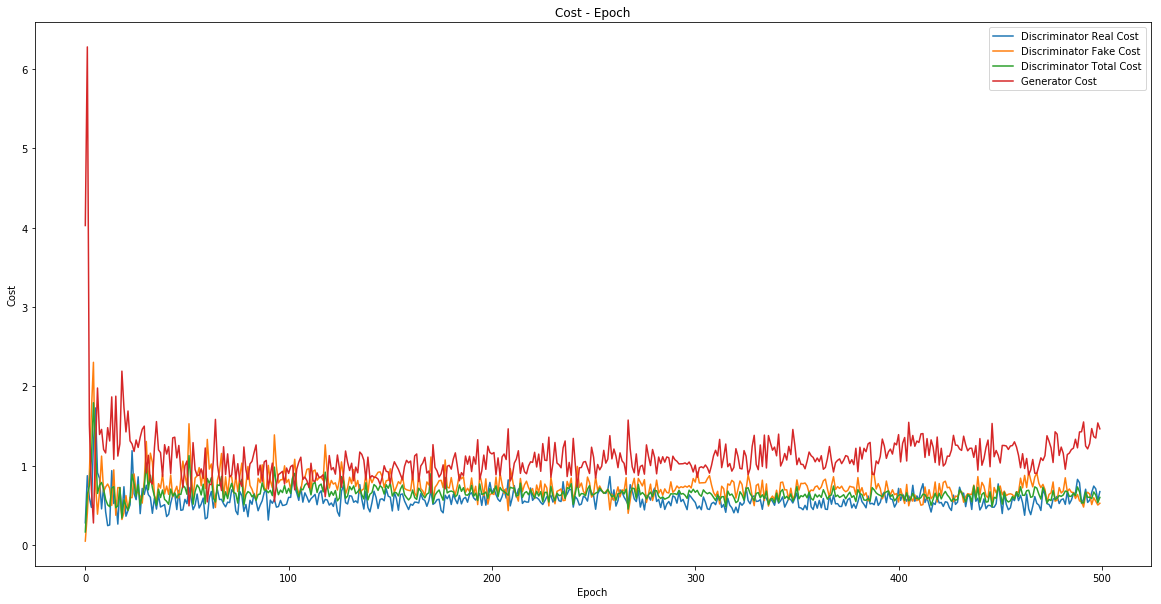

In [8]:
costs = np.array(costs_history).T
plt.figure(figsize=(20, 10))
plt.ylabel('Cost')
plt.xlabel('Epoch')
plt.title('Cost - Epoch')
plt.plot(costs[0], label='Discriminator Real Cost')
plt.plot(costs[1], label='Discriminator Fake Cost')
plt.plot(costs[2], label='Discriminator Total Cost')
plt.plot(costs[3], label='Generator Cost')
plt.legend(loc='best')
plt.show()

Epoch 1:


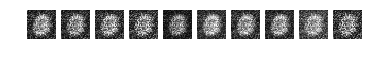

Epoch 2:


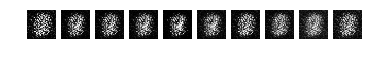

Epoch 3:


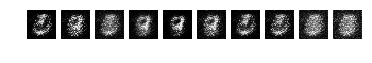

Epoch 4:


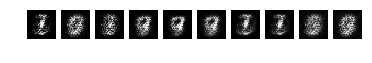

Epoch 5:


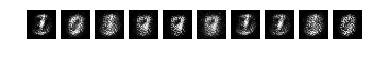

Epoch 6:


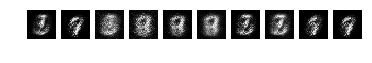

Epoch 7:


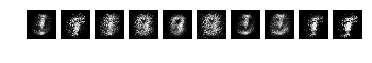

Epoch 8:


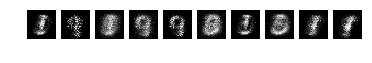

Epoch 9:


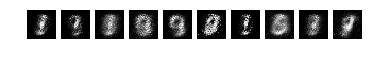

Epoch 10:


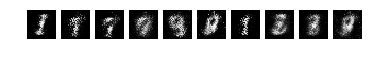

Epoch 11:


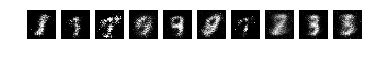

Epoch 12:


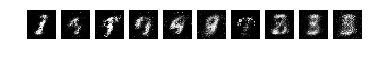

Epoch 13:


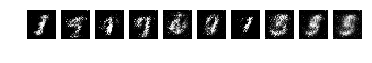

Epoch 14:


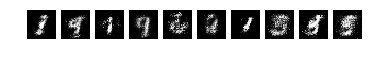

Epoch 15:


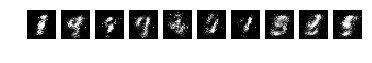

Epoch 16:


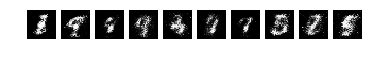

Epoch 17:


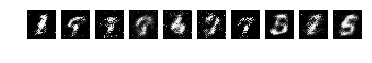

Epoch 18:


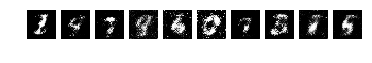

Epoch 19:


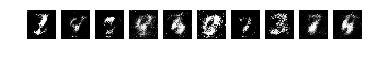

Epoch 20:


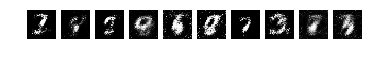

Epoch 21:


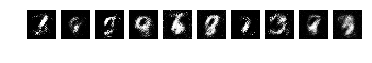

Epoch 22:


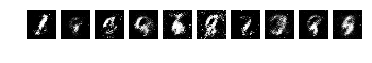

Epoch 23:


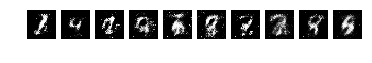

Epoch 24:


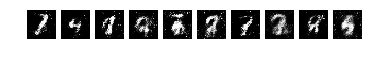

Epoch 25:


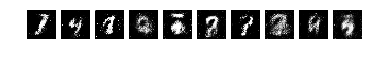

Epoch 26:


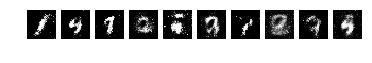

Epoch 27:


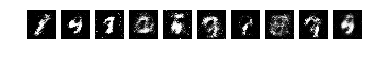

Epoch 28:


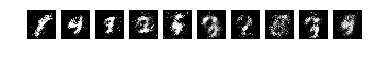

Epoch 29:


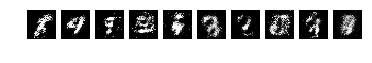

Epoch 30:


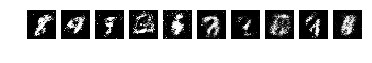

Epoch 31:


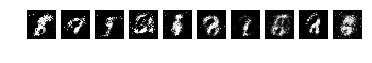

Epoch 32:


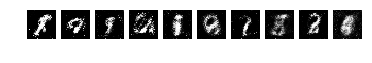

Epoch 33:


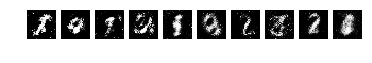

Epoch 34:


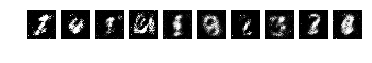

Epoch 35:


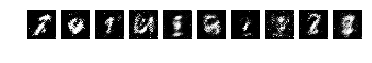

Epoch 36:


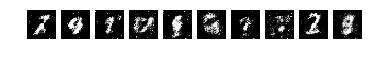

Epoch 37:


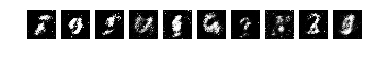

Epoch 38:


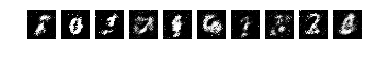

Epoch 39:


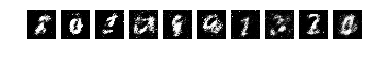

Epoch 40:


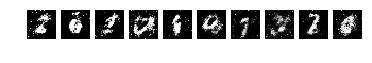

Epoch 41:


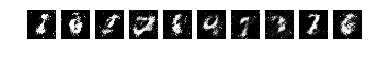

Epoch 42:


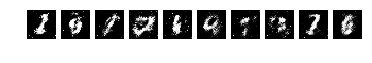

Epoch 43:


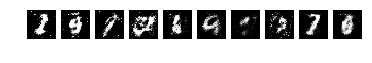

Epoch 44:


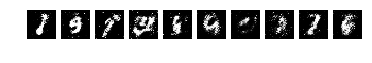

Epoch 45:


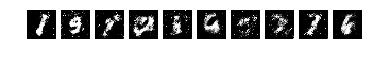

Epoch 46:


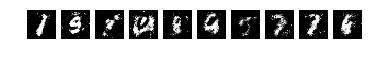

Epoch 47:


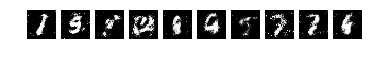

Epoch 48:


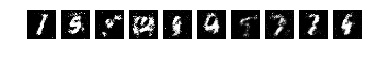

Epoch 49:


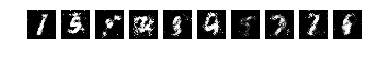

Epoch 50:


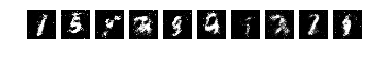

Epoch 51:


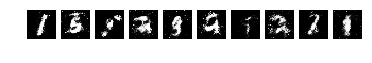

Epoch 52:


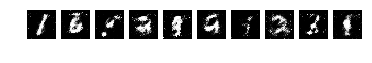

Epoch 53:


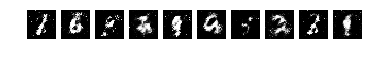

Epoch 54:


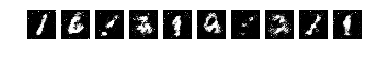

Epoch 55:


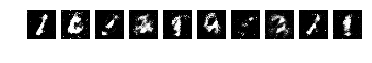

Epoch 56:


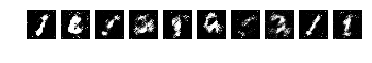

Epoch 57:


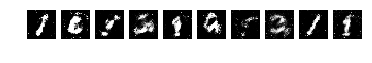

Epoch 58:


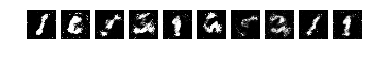

Epoch 59:


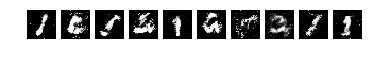

Epoch 60:


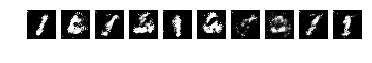

Epoch 61:


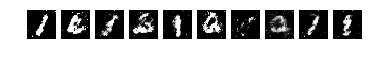

Epoch 62:


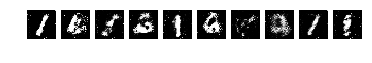

Epoch 63:


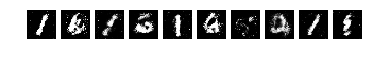

Epoch 64:


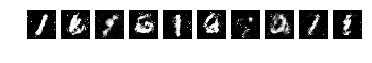

Epoch 65:


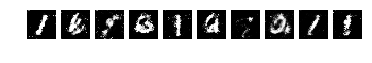

Epoch 66:


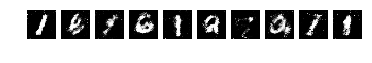

Epoch 67:


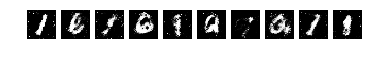

Epoch 68:


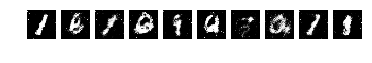

Epoch 69:


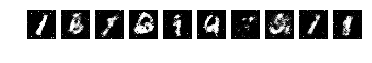

Epoch 70:


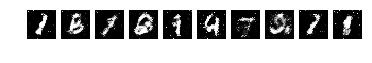

Epoch 71:


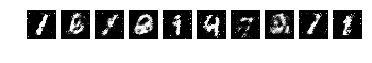

Epoch 72:


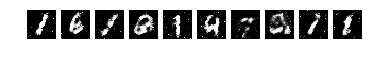

Epoch 73:


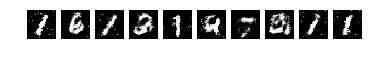

Epoch 74:


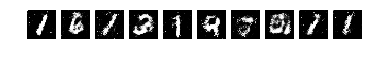

Epoch 75:


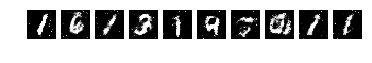

Epoch 76:


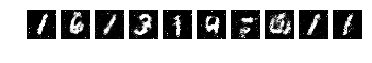

Epoch 77:


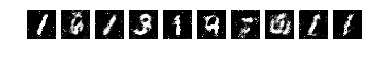

Epoch 78:


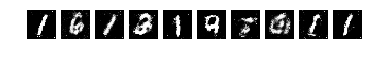

Epoch 79:


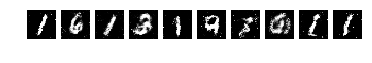

Epoch 80:


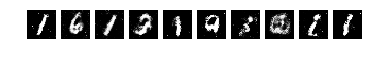

Epoch 81:


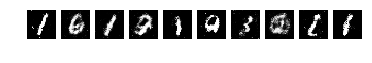

Epoch 82:


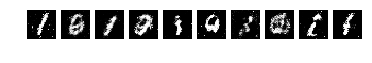

Epoch 83:


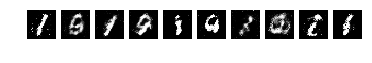

Epoch 84:


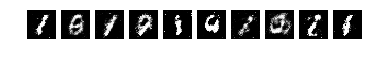

Epoch 85:


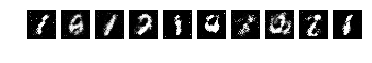

Epoch 86:


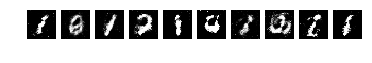

Epoch 87:


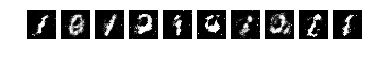

Epoch 88:


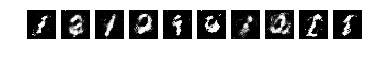

Epoch 89:


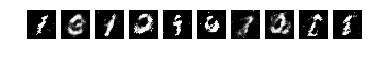

Epoch 90:


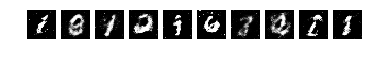

Epoch 91:


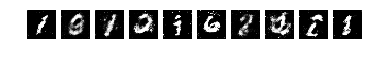

Epoch 92:


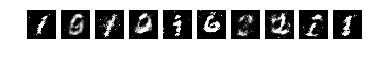

Epoch 93:


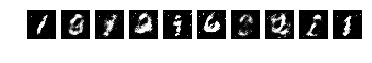

Epoch 94:


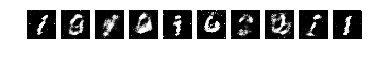

Epoch 95:


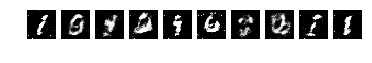

Epoch 96:


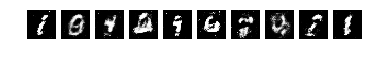

Epoch 97:


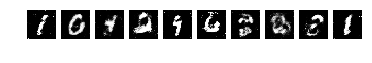

Epoch 98:


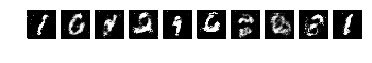

Epoch 99:


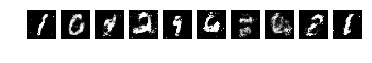

Epoch 100:


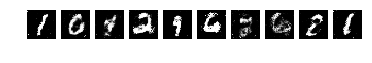

Epoch 101:


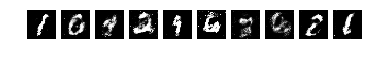

Epoch 102:


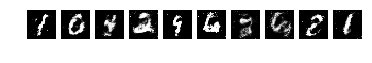

Epoch 103:


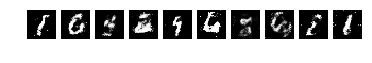

Epoch 104:


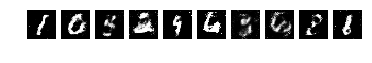

Epoch 105:


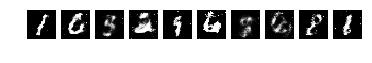

Epoch 106:


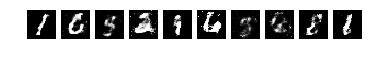

Epoch 107:


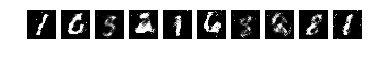

Epoch 108:


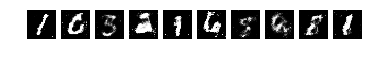

Epoch 109:


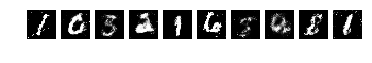

Epoch 110:


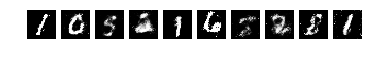

Epoch 111:


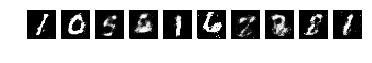

Epoch 112:


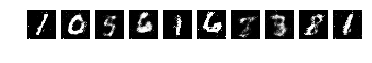

Epoch 113:


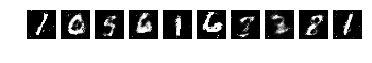

Epoch 114:


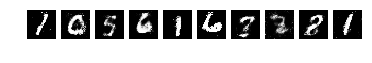

Epoch 115:


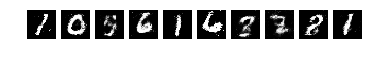

Epoch 116:


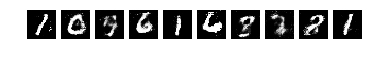

Epoch 117:


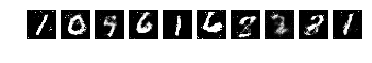

Epoch 118:


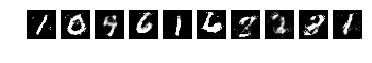

Epoch 119:


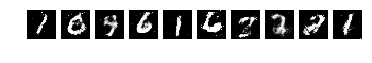

Epoch 120:


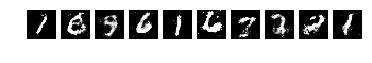

Epoch 121:


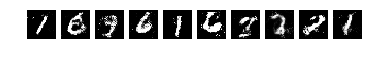

Epoch 122:


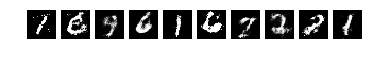

Epoch 123:


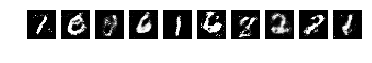

Epoch 124:


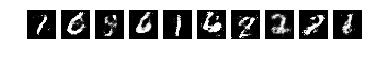

Epoch 125:


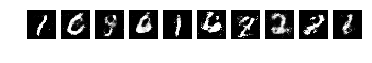

Epoch 126:


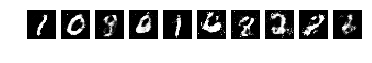

Epoch 127:


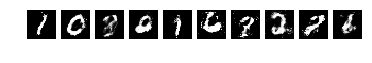

Epoch 128:


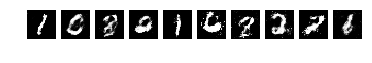

Epoch 129:


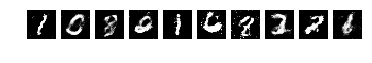

Epoch 130:


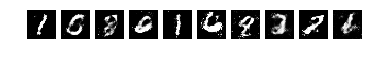

Epoch 131:


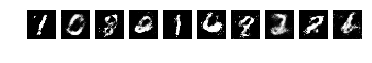

Epoch 132:


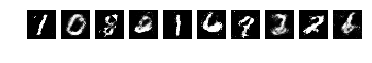

Epoch 133:


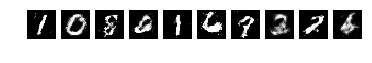

Epoch 134:


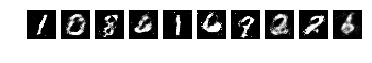

Epoch 135:


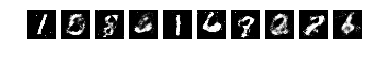

Epoch 136:


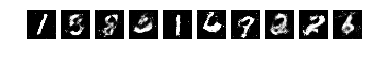

Epoch 137:


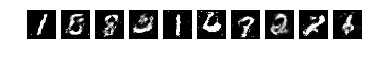

Epoch 138:


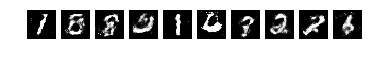

Epoch 139:


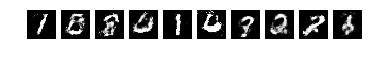

Epoch 140:


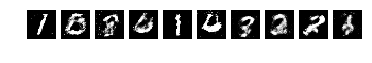

Epoch 141:


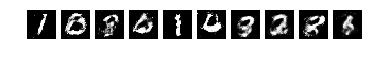

Epoch 142:


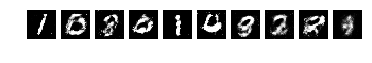

Epoch 143:


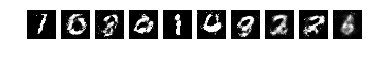

Epoch 144:


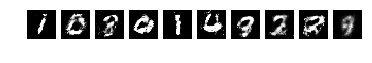

Epoch 145:


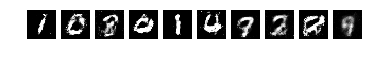

Epoch 146:


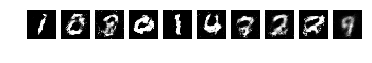

Epoch 147:


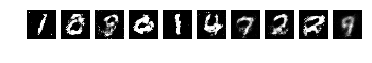

Epoch 148:


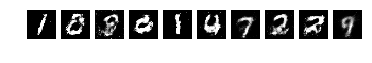

Epoch 149:


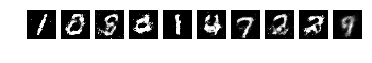

Epoch 150:


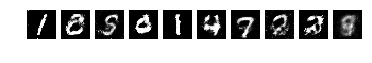

Epoch 151:


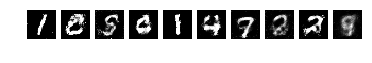

Epoch 152:


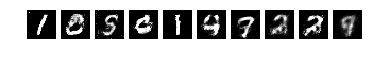

Epoch 153:


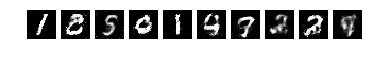

Epoch 154:


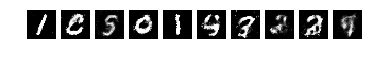

Epoch 155:


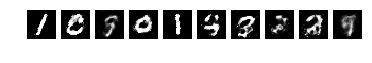

Epoch 156:


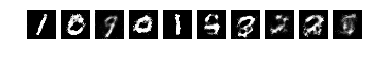

Epoch 157:


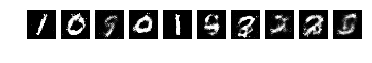

Epoch 158:


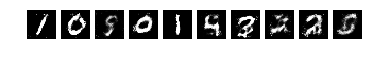

Epoch 159:


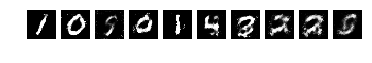

Epoch 160:


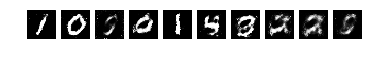

Epoch 161:


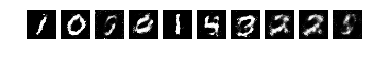

Epoch 162:


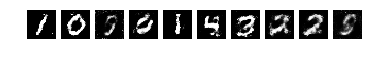

Epoch 163:


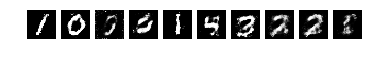

Epoch 164:


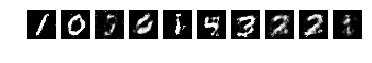

Epoch 165:


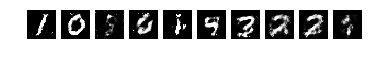

Epoch 166:


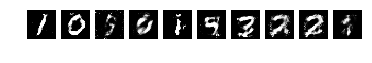

Epoch 167:


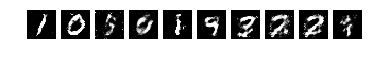

Epoch 168:


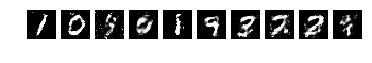

Epoch 169:


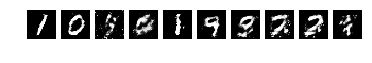

Epoch 170:


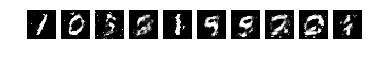

Epoch 171:


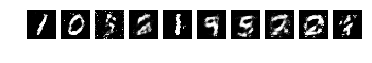

Epoch 172:


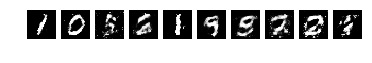

Epoch 173:


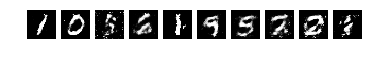

Epoch 174:


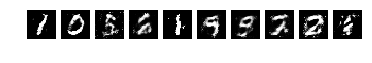

Epoch 175:


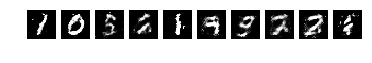

Epoch 176:


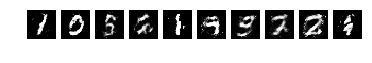

Epoch 177:


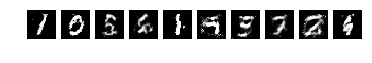

Epoch 178:


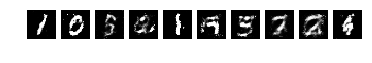

Epoch 179:


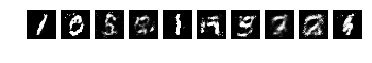

Epoch 180:


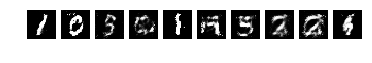

Epoch 181:


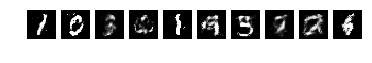

Epoch 182:


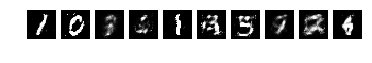

Epoch 183:


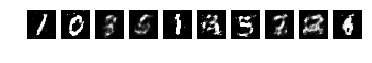

Epoch 184:


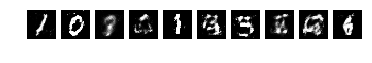

Epoch 185:


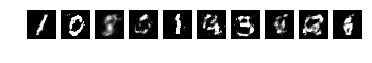

Epoch 186:


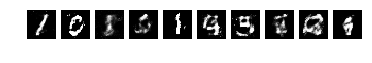

Epoch 187:


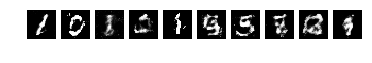

Epoch 188:


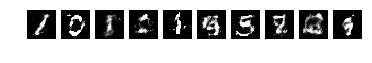

Epoch 189:


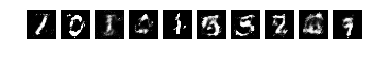

Epoch 190:


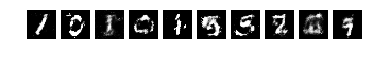

Epoch 191:


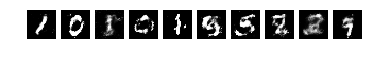

Epoch 192:


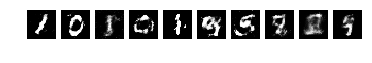

Epoch 193:


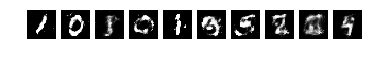

Epoch 194:


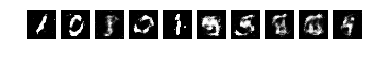

Epoch 195:


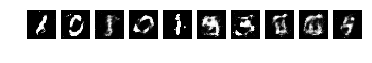

Epoch 196:


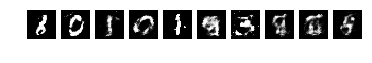

Epoch 197:


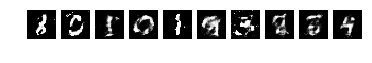

Epoch 198:


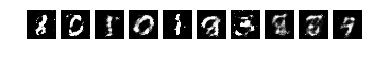

Epoch 199:


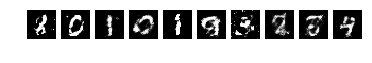

Epoch 200:


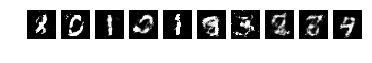

Epoch 201:


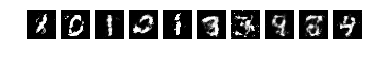

Epoch 202:


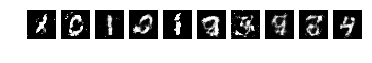

Epoch 203:


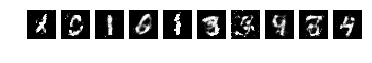

Epoch 204:


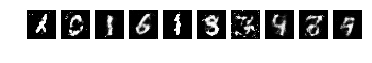

Epoch 205:


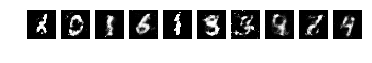

Epoch 206:


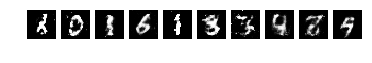

Epoch 207:


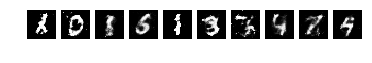

Epoch 208:


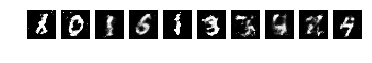

Epoch 209:


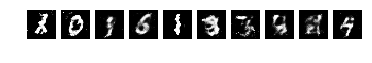

Epoch 210:


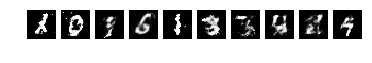

Epoch 211:


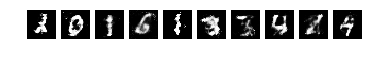

Epoch 212:


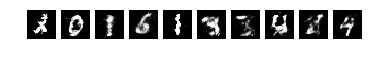

Epoch 213:


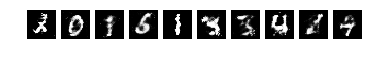

Epoch 214:


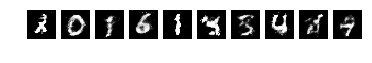

Epoch 215:


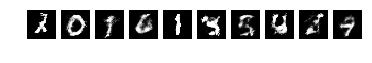

Epoch 216:


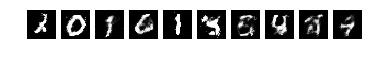

Epoch 217:


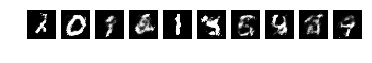

Epoch 218:


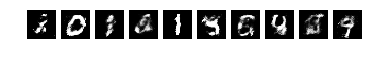

Epoch 219:


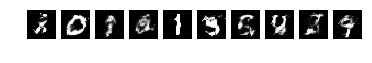

Epoch 220:


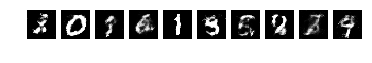

Epoch 221:


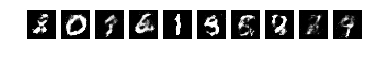

Epoch 222:


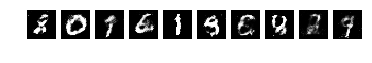

Epoch 223:


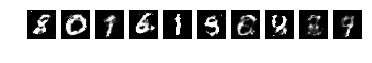

Epoch 224:


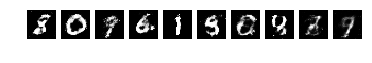

Epoch 225:


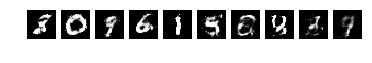

Epoch 226:


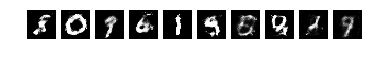

Epoch 227:


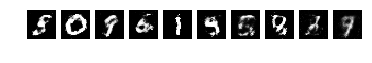

Epoch 228:


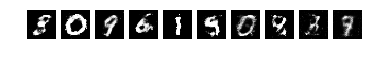

Epoch 229:


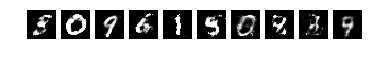

Epoch 230:


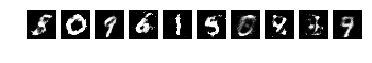

Epoch 231:


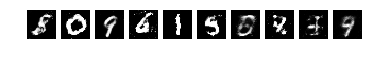

Epoch 232:


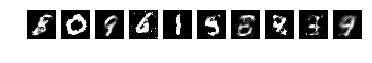

Epoch 233:


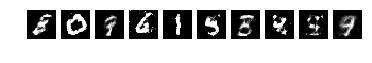

Epoch 234:


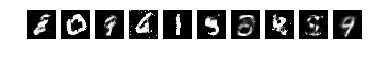

Epoch 235:


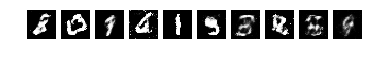

Epoch 236:


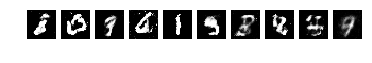

Epoch 237:


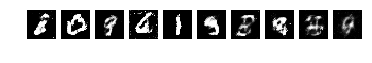

Epoch 238:


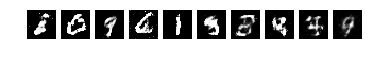

Epoch 239:


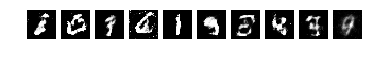

Epoch 240:


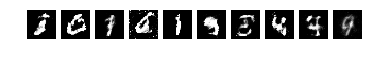

Epoch 241:


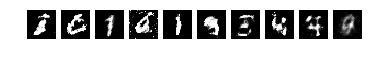

Epoch 242:


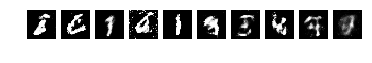

Epoch 243:


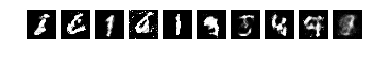

Epoch 244:


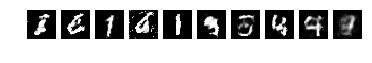

Epoch 245:


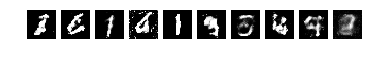

Epoch 246:


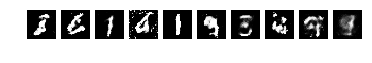

Epoch 247:


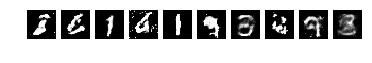

Epoch 248:


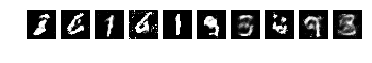

Epoch 249:


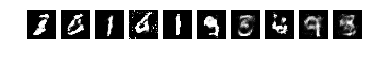

Epoch 250:


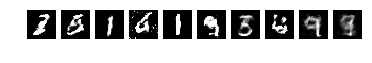

Epoch 251:


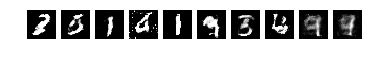

Epoch 252:


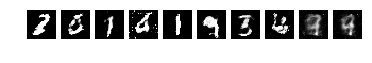

Epoch 253:


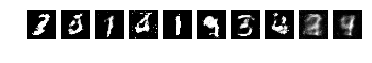

Epoch 254:


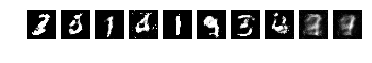

Epoch 255:


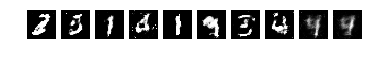

Epoch 256:


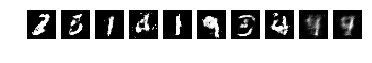

Epoch 257:


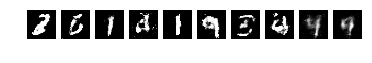

Epoch 258:


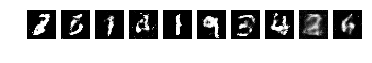

Epoch 259:


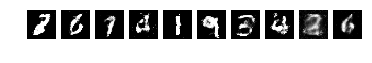

Epoch 260:


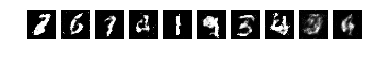

Epoch 261:


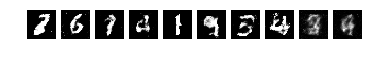

Epoch 262:


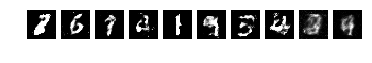

Epoch 263:


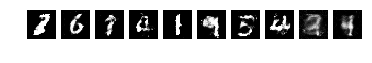

Epoch 264:


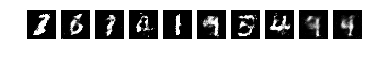

Epoch 265:


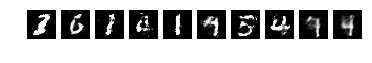

Epoch 266:


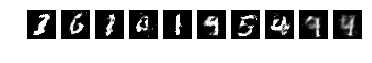

Epoch 267:


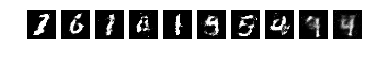

Epoch 268:


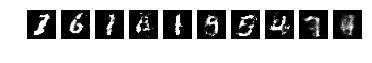

Epoch 269:


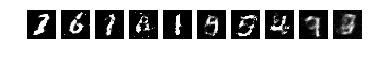

Epoch 270:


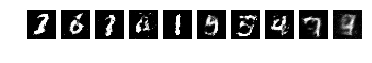

Epoch 271:


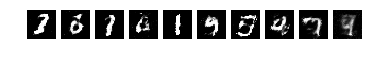

Epoch 272:


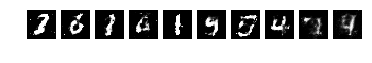

Epoch 273:


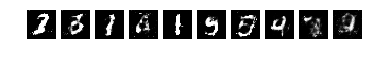

Epoch 274:


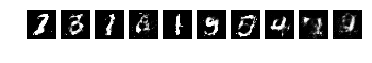

Epoch 275:


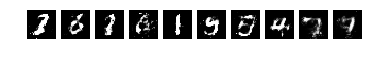

Epoch 276:


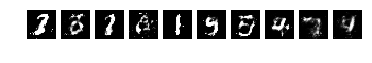

Epoch 277:


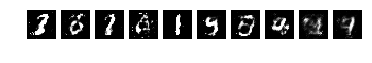

Epoch 278:


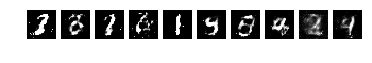

Epoch 279:


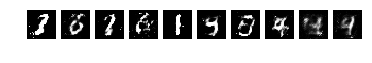

Epoch 280:


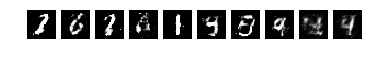

Epoch 281:


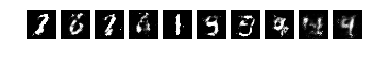

Epoch 282:


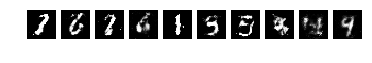

Epoch 283:


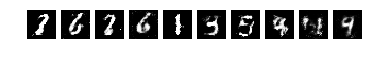

Epoch 284:


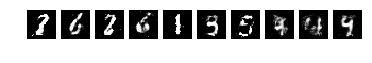

Epoch 285:


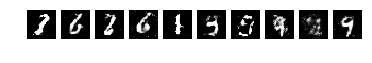

Epoch 286:


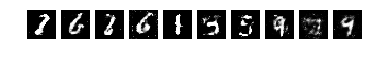

Epoch 287:


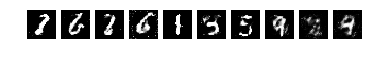

Epoch 288:


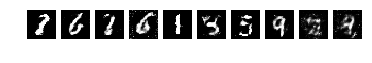

Epoch 289:


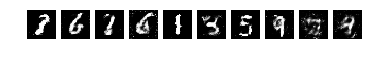

Epoch 290:


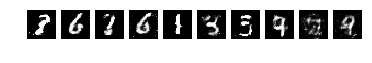

Epoch 291:


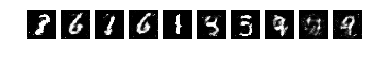

Epoch 292:


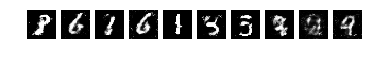

Epoch 293:


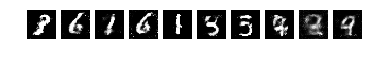

Epoch 294:


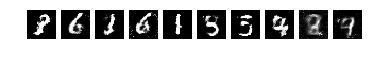

Epoch 295:


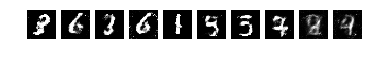

Epoch 296:


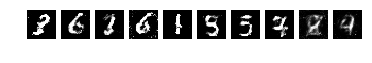

Epoch 297:


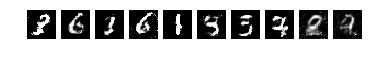

Epoch 298:


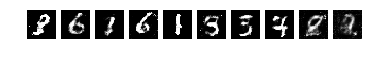

Epoch 299:


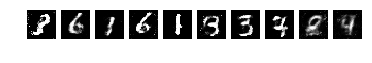

Epoch 300:


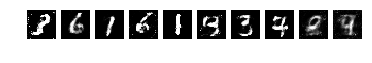

Epoch 301:


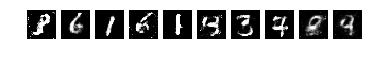

Epoch 302:


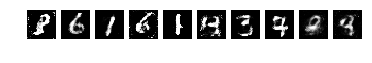

Epoch 303:


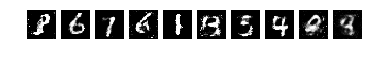

Epoch 304:


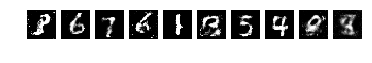

Epoch 305:


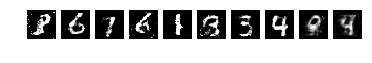

Epoch 306:


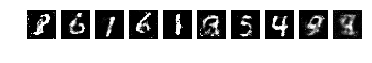

Epoch 307:


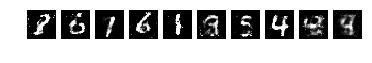

Epoch 308:


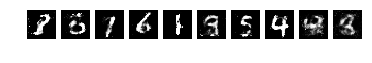

Epoch 309:


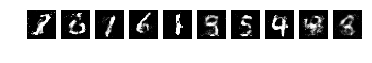

Epoch 310:


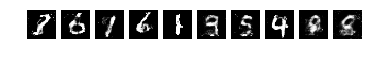

Epoch 311:


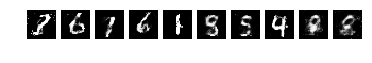

Epoch 312:


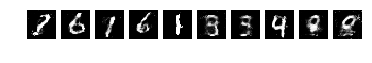

Epoch 313:


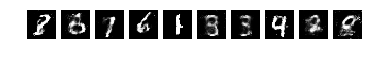

Epoch 314:


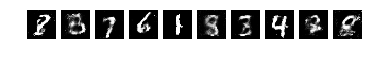

Epoch 315:


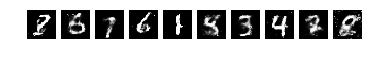

Epoch 316:


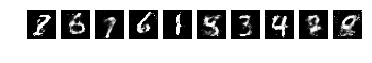

Epoch 317:


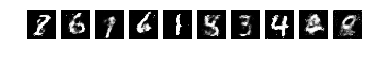

Epoch 318:


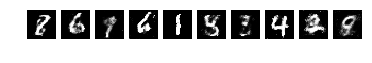

Epoch 319:


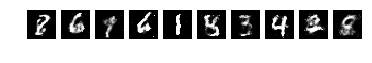

Epoch 320:


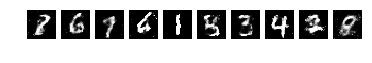

Epoch 321:


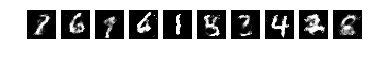

Epoch 322:


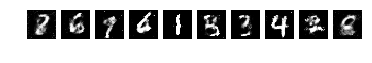

Epoch 323:


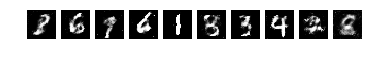

Epoch 324:


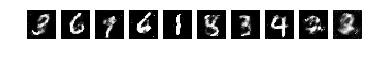

Epoch 325:


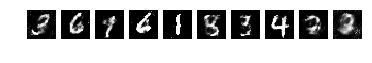

Epoch 326:


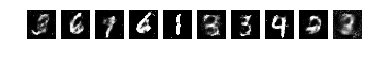

Epoch 327:


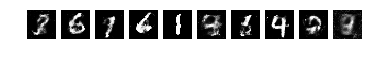

Epoch 328:


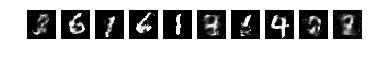

Epoch 329:


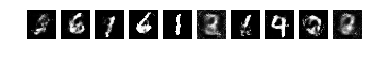

Epoch 330:


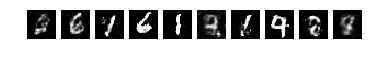

Epoch 331:


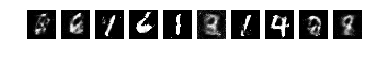

Epoch 332:


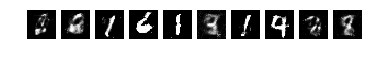

Epoch 333:


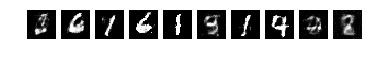

Epoch 334:


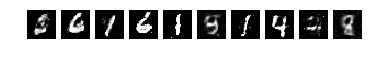

Epoch 335:


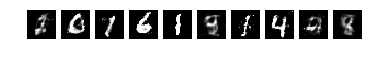

Epoch 336:


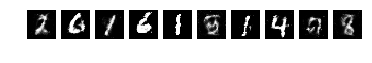

Epoch 337:


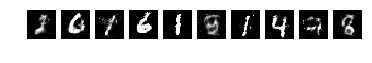

Epoch 338:


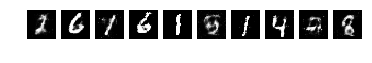

Epoch 339:


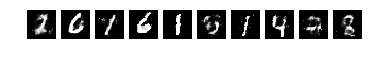

Epoch 340:


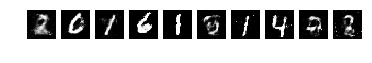

Epoch 341:


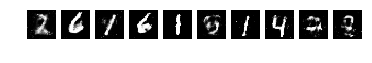

Epoch 342:


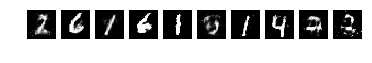

Epoch 343:


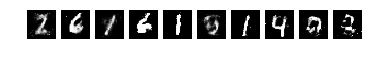

Epoch 344:


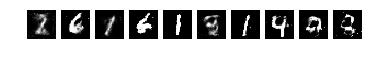

Epoch 345:


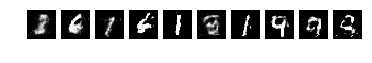

Epoch 346:


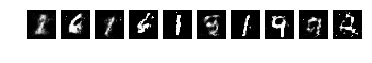

Epoch 347:


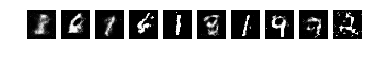

Epoch 348:


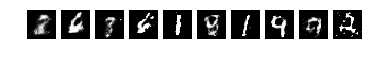

Epoch 349:


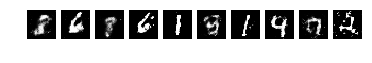

Epoch 350:


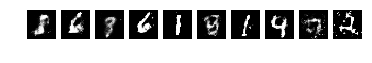

Epoch 351:


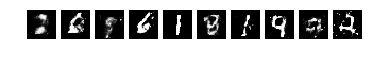

Epoch 352:


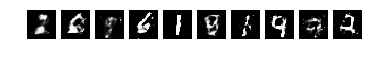

Epoch 353:


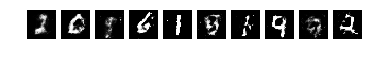

Epoch 354:


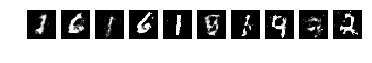

Epoch 355:


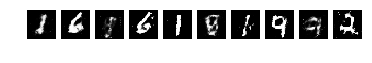

Epoch 356:


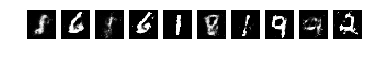

Epoch 357:


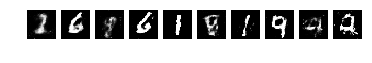

Epoch 358:


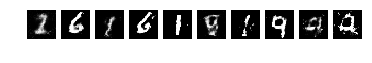

Epoch 359:


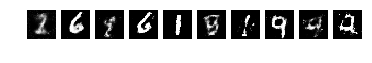

Epoch 360:


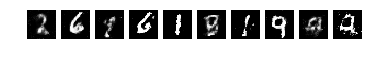

Epoch 361:


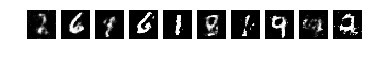

Epoch 362:


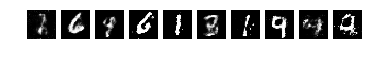

Epoch 363:


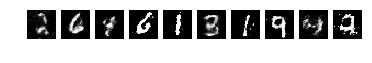

Epoch 364:


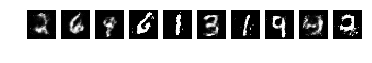

Epoch 365:


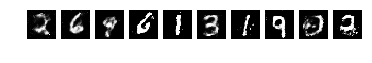

Epoch 366:


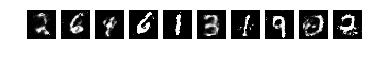

Epoch 367:


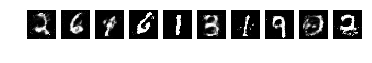

Epoch 368:


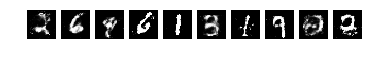

Epoch 369:


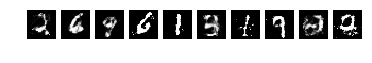

Epoch 370:


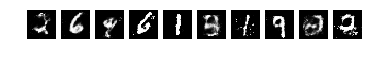

Epoch 371:


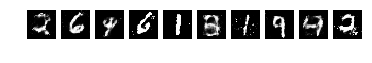

Epoch 372:


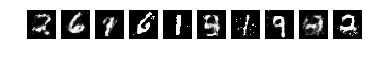

Epoch 373:


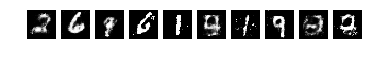

Epoch 374:


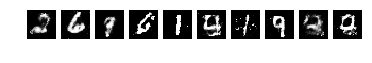

Epoch 375:


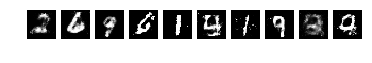

Epoch 376:


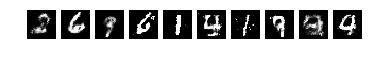

Epoch 377:


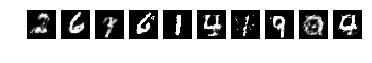

Epoch 378:


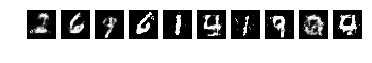

Epoch 379:


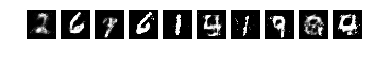

Epoch 380:


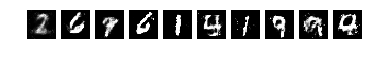

Epoch 381:


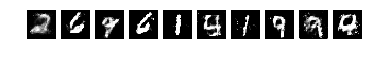

Epoch 382:


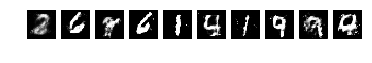

Epoch 383:


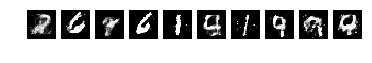

Epoch 384:


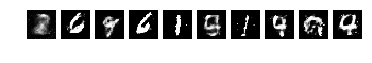

Epoch 385:


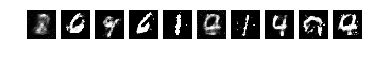

Epoch 386:


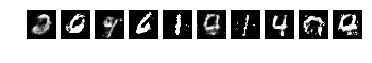

Epoch 387:


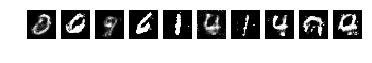

Epoch 388:


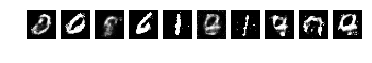

Epoch 389:


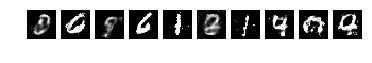

Epoch 390:


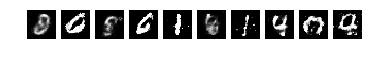

Epoch 391:


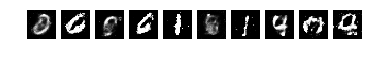

Epoch 392:


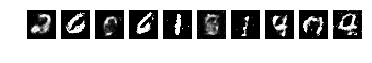

Epoch 393:


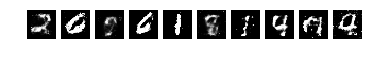

Epoch 394:


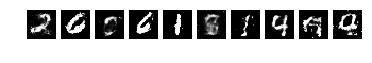

Epoch 395:


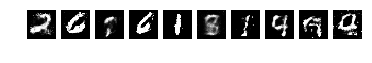

Epoch 396:


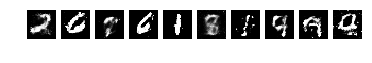

Epoch 397:


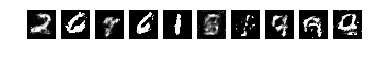

Epoch 398:


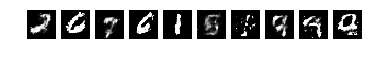

Epoch 399:


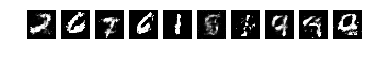

Epoch 400:


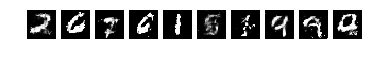

Epoch 401:


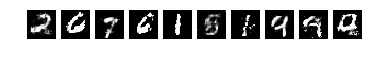

Epoch 402:


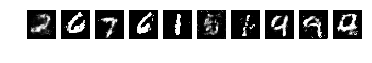

Epoch 403:


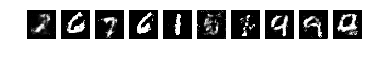

Epoch 404:


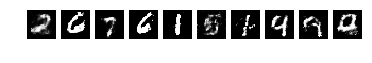

Epoch 405:


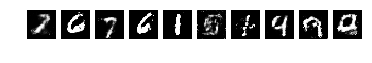

Epoch 406:


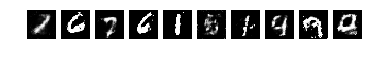

Epoch 407:


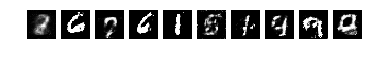

Epoch 408:


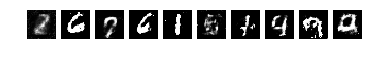

Epoch 409:


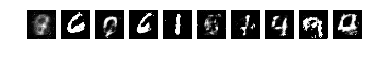

Epoch 410:


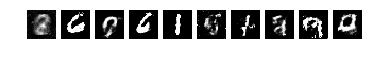

Epoch 411:


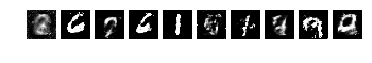

Epoch 412:


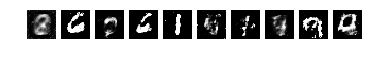

Epoch 413:


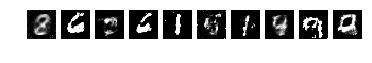

Epoch 414:


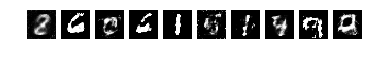

Epoch 415:


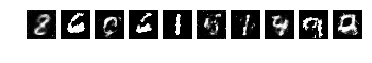

Epoch 416:


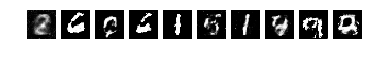

Epoch 417:


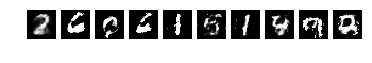

Epoch 418:


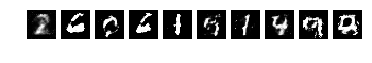

Epoch 419:


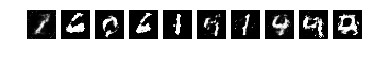

Epoch 420:


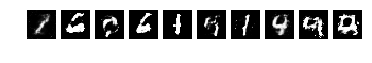

Epoch 421:


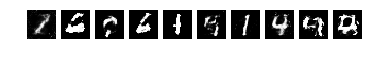

Epoch 422:


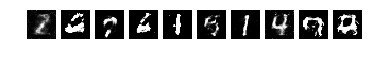

Epoch 423:


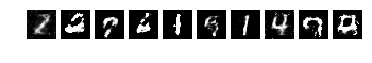

Epoch 424:


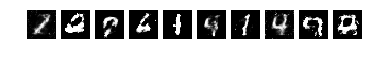

Epoch 425:


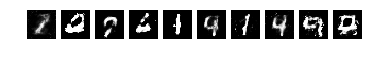

Epoch 426:


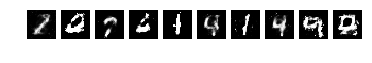

Epoch 427:


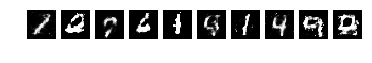

Epoch 428:


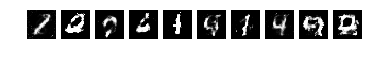

Epoch 429:


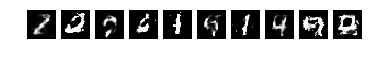

Epoch 430:


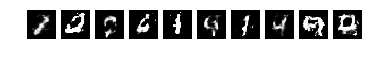

Epoch 431:


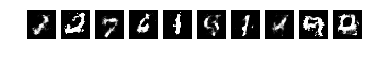

Epoch 432:


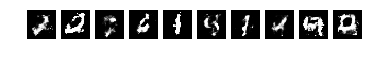

Epoch 433:


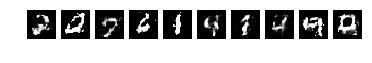

Epoch 434:


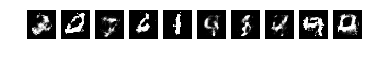

Epoch 435:


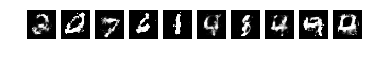

Epoch 436:


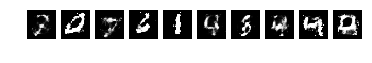

Epoch 437:


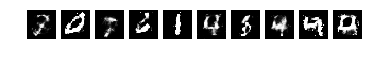

Epoch 438:


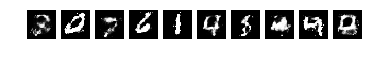

Epoch 439:


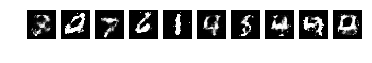

Epoch 440:


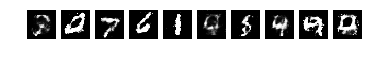

Epoch 441:


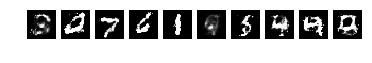

Epoch 442:


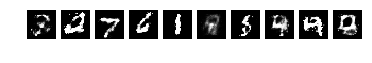

Epoch 443:


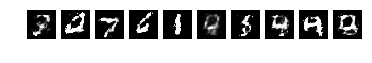

Epoch 444:


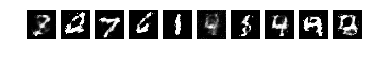

Epoch 445:


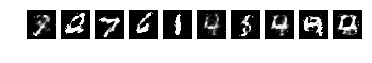

Epoch 446:


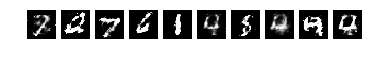

Epoch 447:


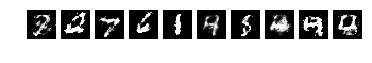

Epoch 448:


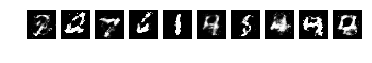

Epoch 449:


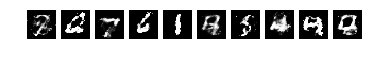

Epoch 450:


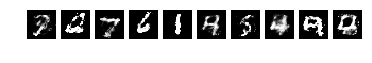

Epoch 451:


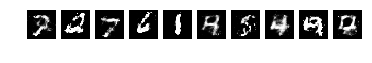

Epoch 452:


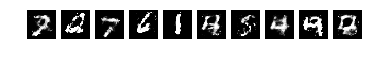

Epoch 453:


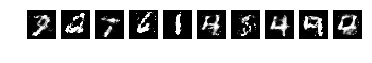

Epoch 454:


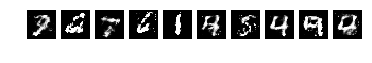

Epoch 455:


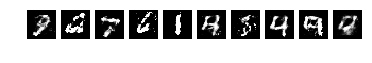

Epoch 456:


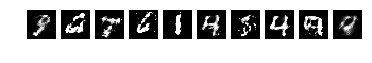

Epoch 457:


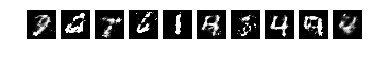

Epoch 458:


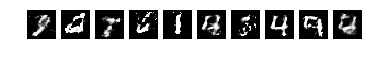

Epoch 459:


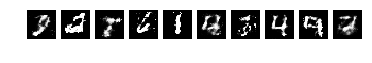

Epoch 460:


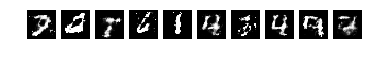

Epoch 461:


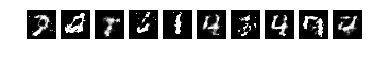

Epoch 462:


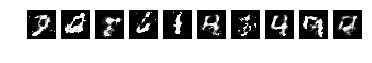

Epoch 463:


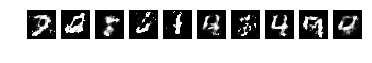

Epoch 464:


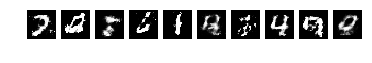

Epoch 465:


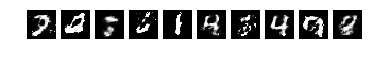

Epoch 466:


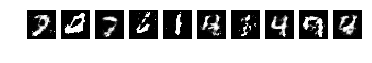

Epoch 467:


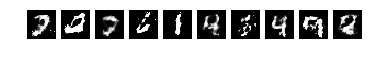

Epoch 468:


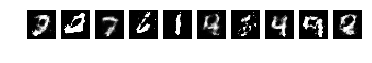

Epoch 469:


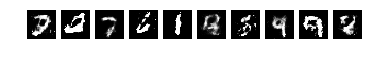

Epoch 470:


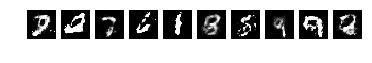

Epoch 471:


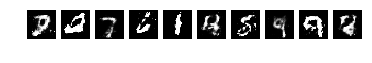

Epoch 472:


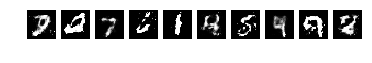

Epoch 473:


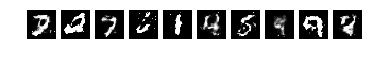

Epoch 474:


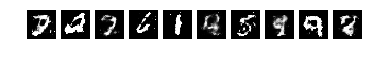

Epoch 475:


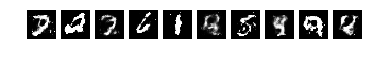

Epoch 476:


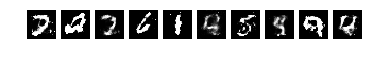

Epoch 477:


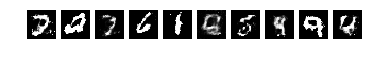

Epoch 478:


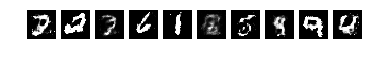

Epoch 479:


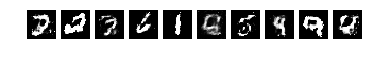

Epoch 480:


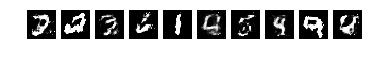

Epoch 481:


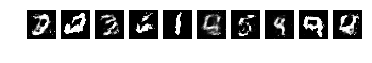

Epoch 482:


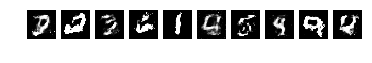

Epoch 483:


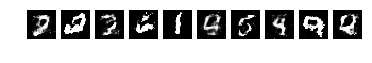

Epoch 484:


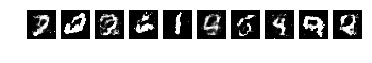

Epoch 485:


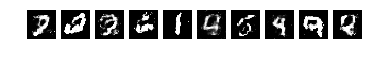

Epoch 486:


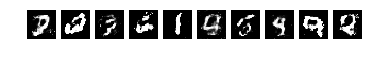

Epoch 487:


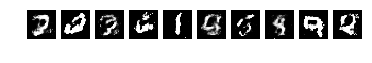

Epoch 488:


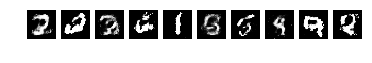

Epoch 489:


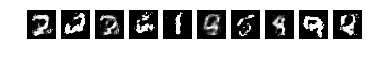

Epoch 490:


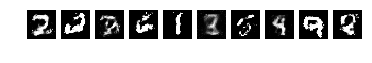

Epoch 491:


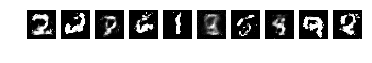

Epoch 492:


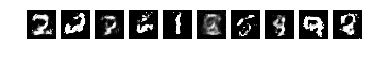

Epoch 493:


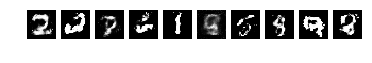

Epoch 494:


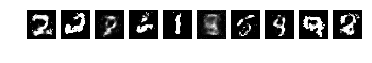

Epoch 495:


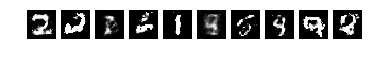

Epoch 496:


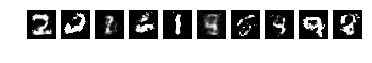

Epoch 497:


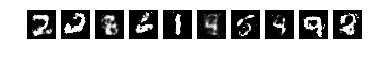

Epoch 498:


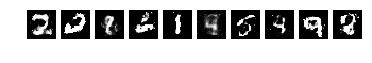

Epoch 499:


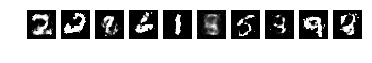

Epoch 500:


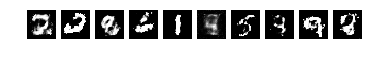

In [9]:
for i in range(hyperparams['epoch']):
    print('Epoch {}:'.format(i + 1))
    for j in range(hyperparams['sample_size']):
        plt.subplot(1, hyperparams['sample_size'], j + 1)
        plt.axis('off')
        plt.imshow(generate_sample_history[i, j].reshape(28, 28), cmap='gray')   
    plt.show()